# Applied Machine Learning: Summative Code 2/2 (Prediction)

**Candidate Number: 1047904**

**07 May, 2021**

<font color=red>**README:**</font> 

- Pre-processing and modelling was spread across two separate *Jupyter Notebooks* for performance reasons. 
- **To replicate reported analyses, both notebooks need to be in the same location as the data folder FFChallenge_v5 and run in the following sequence** 
1. Run notebook “CODE_Explore_1047904_Applied Machine Learning_Summative.ipynb" (the other notebook) first to write out the pre-processed data and associated dytpe dictionary into *FFChallenge_v5* folder. 
2. Run notebook “CODE_Predict_1047904_Applied Machine Learning_Summative.ipynb" (this notebook) second to pick up previously written out by the first notebook. This will allow you to re-run all prediction experiments

- In addition: **File FFMetadata_v07.csv needs be placed inside the FFChallenge_v5 folder before running any notebook**

<font color=red>**Remark on Notation:**</font> 

The dataset has been split into train and test ahead of analysis 

- **X_train, y_train** denotes the training portion **used for model training and hyperparameter tuning via cross-validation**
- **X_CV, y_CV refers to the test set portion** 
- In the same spirit, **function argument placholders for test set portions** were **denoted as X_val and y_val**

This notation is unfortunate and has been recognized as a source of confusion too close to the submission deadline to adapt relevant portions of the code for better legibility

## Library Imports

In [408]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import os
import pickle
import timeit

import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import datetime
import time, math, re
import missingno as msno
import math
from textwrap import wrap

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import accuracy_score


from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import lightgbm as lgb

%matplotlib inline

## Functions

### Pre-Processing Pipeline Utilities

In [63]:
def impute_features (df_train,df_val,cols,strat,imputer,verbose=True):
    """impute feature subset
    
    Parameters: 
    
    arg1 : train df to learn imputation from 
    arg2 : val df to apply learned imputation to
    arg3 : imputation strategy
    arg4 : whether or not to apply multivariate imputation
    
    returns:
    
    Imputed slices for train and val sets
    
    """
    if verbose:
        print(f"{len(cols)} columns imputed with {strat} using {imputer} imputation")
    
    
    temp_train = df_train.copy()
    temp_val = df_val.copy()
    
    if imputer == "multivar":
        
        #instantiate iterative imputer
        imp = IterativeImputer(missing_values=np.nan,max_iter=10, random_state=0, initial_strategy=strat,n_nearest_features=5)
        
        #fit on train; transform train & val 
        temp_train.loc[:,cols] = imp.fit_transform(df_train.loc[:,cols])
        temp_val.loc[:,cols] = imp.transform(df_val.loc[:,cols])       
        
        return temp_train, temp_val,""
        
    if imputer == "simple":
        
        #instantiate simple imputer
        imp = SimpleImputer(missing_values=np.nan, strategy=strat)
        
        #fit on train; transform train & val 
        temp_train.loc[:,cols] = imp.fit_transform(df_train.loc[:,cols])
        temp_val.loc[:,cols] = imp.transform(df_val.loc[:,cols])
        
        #return dict with imputation value per col (not available for Iterative imputer due to methodology)
        imp_dict = {k:v for k,v in zip(cols,imp.statistics_)}
        
        return temp_train, temp_val, imp_dict

def one_hot_encode(df_train,df_val,cols,verbose = True,drop_first=False):
    """impute feature subset
    
    Parameters: 
    
    arg1 : train df to learn encoding from 
    arg2 : val df to apply learned encoding to
    arg3 : column array to one-hot encode
    arg4 : whether or not to print results report 
    
    returns:
    
    new train and val dfs with one-hot encoded columns
    
    """
    
    #extract df shares elective for encoding 
    df_train_to_encode = df_train.loc[:,cols]
    df_val_to_encode = df_val.loc[:,cols]
    
    #extract original column names for renaming
    to_encode_cols = df_train_to_encode.columns
    
    if verbose:
        print(f"{len(to_encode_cols)} features will be one-hot encoded")
    
    if drop_first:
        
        #instantiate encoder
        enc = OneHotEncoder(handle_unknown='error',sparse=False,drop="first")
        if verbose:
            print("Reference category of one-hot encoded feature will be dropped")
    
    else:
        
        #instantiate encoder
        enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
        if verbose:
            print("Reference category will be maintained")
    
    #fit encoder on train set
    enc.fit(df_train_to_encode)
    
    #transform train set based on learned encoding
    df_train_encoded = pd.DataFrame(enc.transform(df_train_to_encode),columns = enc.get_feature_names(to_encode_cols))
    #maintain original indices (Challenger IDs)
    df_train_encoded.set_index(df_train.index,inplace=True)
    
    #transform val set based on learned encoding
    df_val_encoded = pd.DataFrame(enc.transform(df_val_to_encode),columns = enc.get_feature_names(to_encode_cols))
    #maintain original indices (Challenger IDs)
    df_val_encoded.set_index(df_val.index,inplace=True)
    
    #drop parent columns used for encoding in orignal dfs
    df_train_unencoded = df_train.drop(to_encode_cols,axis=1)
    df_val_unencoded = df_val.drop(to_encode_cols,axis=1)
    
    #concatenate one hot encoded columns to pruned dfs
    df_train_new = pd.concat([df_train_encoded,df_train_unencoded],axis=1)
    df_val_new = pd.concat([df_val_encoded,df_val_unencoded],axis=1)
    
    #validate shapes
    assert df_train.shape[1] - df_train_to_encode.shape[1] + df_train_encoded.shape[1] == df_train_new.shape[1]
    assert df_val.shape[1] - df_val_to_encode.shape[1] + df_val_encoded.shape[1] == df_val_new.shape[1]
    assert df_train_new.shape[1] == df_val_new.shape[1]
    
    if verbose:
        print ("\n","="*3 + " Training Set " + "="*3,"\n")
        print(f"Shape Original df: {df_train.shape}")
        print(f"Shape unencoded_df df: {df_train_unencoded.shape}")
        print(f"Shape to_encode_df df: {df_train_to_encode.shape}")
        print(f"Shape encoded_df df: {df_train_encoded.shape}")
        print(f"Shape new df: {df_train_new.shape}")
        
        print ("\n","="*3  + " CV Set " +"="*3,"\n")
        print(f"Shape Original df: {df_val.shape}")
        print(f"Shape unencoded_df df: {df_val_unencoded.shape}")
        print(f"Shape to_encode_df df: {df_val_to_encode.shape}")
        print(f"Shape encoded_df df: {df_val_encoded.shape}")
        print(f"Shape new df: {df_val_new.shape}")
        
    return  df_train_new, df_val_new   

def retain_response_only (X_train,y_train,X_val,y_val,variable,verbose=True):
    """only retain X instances with non-NA response entry
    
    args: 
    
    arg 1-4: X,y dfs for train and test
    arg 5: response variable of interest 
    arg 6: whether or not to print variable lost report
    
    returns: 
    
    X,y for train and test on variable of interest
    
    """
    
    # drop NAs in X and y in train set
    y_train_temp = y_train[variable].dropna()
    X_train_temp = X_train.loc[y_train_temp.index.values]
    
    # drop NAs in X and y in val set
    y_val_temp = y_val[variable].dropna()
    X_val_temp = X_val.loc[y_val_temp.index.values]
    
    if verbose:
        
        print(f"Observations lost in Train set: {X_train.shape[0]-X_train_temp.shape[0]}")
        print(f"Observations lost in Val set: {X_val.shape[0]-X_val_temp.shape[0]}")
    
    return X_train_temp,y_train_temp,X_val_temp,y_val_temp


def upsample (X_train_uni,y_train_uni,variable,verbose=True):
    
    """upsample minority class
    
    Args:
    
    arg(1): train set observations with non-NA response values
    arg(2): train response values
    arg(3): response variable name 
    arg(4): whether or not to print schema report 
    
    return:
    
    balanced train set 
    
    """
    #set seed for replicability
    np.random.seed(42)
    
    #retrieve majority class label
    majority_class = y_train_uni.value_counts().sort_values(ascending=False).index[0]
    
    #create boolean mask to seperate class labels 
    minority_mask =  y_train_uni.values != majority_class
    
    #seperate out minority and majority class observations
    minority_features = X_train_uni.values[minority_mask]
    majority_features = X_train_uni.values[~minority_mask]
    
    #seperate out minority and majority class class labels
    minority_labels = y_train_uni.values[minority_mask]
    majority_labels = y_train_uni.values[~minority_mask]
    
    #get indicies 
    ids = np.arange(len(minority_features))
    
    #draw indices at random; draws w/ replacement matching volume of majority class
    choices = np.random.choice(ids, len(majority_features))
    
    #oversample minority class 
    res_minority_features = minority_features[choices]
    res_minority_labels = minority_labels[choices]
        
    #recreate dataframe 
    resampled_features = np.concatenate([res_minority_features, majority_features], axis=0)
    resampled_labels = np.concatenate([res_minority_labels,majority_labels], axis=0)
    
    #shuffle order
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    
    
    resampled_X_train = pd.DataFrame(resampled_features[order],columns = X_train_uni.columns)
    resampled_X_train = resampled_X_train.astype(dtype= dict(X_train.dtypes))
    resampled_y_train = pd.Series(resampled_labels[order],name=variable)
    
    if verbose:
        print ("="*3+ " Class Imbalances " +"="*3)
        print(y_train_uni.value_counts())
        print(f"Shape of upsampled minority class: # X: {res_minority_features.shape}  # y: {res_minority_labels.shape}")
        print(f"Shape of majority class: # Rows:  # X: {majority_features.shape}  # y: {majority_labels.shape}")
        print(f"Shape of resulting train set: # Rows:  # X_train: {resampled_X_train.shape}  # y_train: {resampled_y_train.shape}")
    
    return resampled_X_train,resampled_y_train

def scale_X(df_train,df_val,cols,verbose=True):
    """standardize X dfs for train and val sets for selected columns
    
    Args:
    
    arg(1): training feature df
    arg(2): validation feature df
    arg(3): columns to be standardized
    
    returns:
    
    scaled slices for train and test set
    """
    
    scaler_dict = dict()
    
    #take safe df copies 
    df_train_temp = df_train.copy()
    df_val_temp = df_val.copy()
    
    if verbose:
        print(f"Standardizing {len(cols)} features...")
    
    #instantiate scaler
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #fit scaler on train set 
    scaler.fit(df_train.loc[:,cols])
    
    #transform train and val set based on learned scaling
    df_train_temp.loc[:,cols] = scaler.transform(df_train.loc[:,cols])
    df_val_temp.loc[:,cols] = scaler.transform(df_val.loc[:,cols])
    
    #save means and std per feature for reference purposes
    for f,m,std in zip(cols,scaler.mean_,scaler.scale_):
        scaler_dict[f] = [m,std]
        
    return df_train_temp,df_val_temp,scaler_dict

def scale_y(y_train,y_val,y_reg,verbose=True):
    """standardize X dfs for train and val sets for selected columns
    
    Args:
    
    arg(1): train responses
    arg(2): validation responses
    arg(3): continuous columns in scope for scaling
    
    returns:
    
    response dfs scaled for continuous responses 
    """
    
    scaler_dict = dict()
    
    #take safe df copies 
    y_train_temp = y_train.copy()
    y_val_temp = y_val.copy()
    
    if verbose:
        print(f"Standardizing cont. responses {y_reg}...")
    
    #instantiate scaler
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    #fit scaler on train set 
    scaler.fit(y_train.loc[:,y_reg])
    
    #transform train and val set based on learned scaling
    y_train_temp.loc[:,y_reg] = scaler.transform(y_train.loc[:,y_reg])
    y_val_temp.loc[:,y_reg] = scaler.transform(y_val.loc[:,y_reg])
    
    #save means and std per feature for reference purposes
    for f,m,std in zip(y_reg,scaler.mean_,scaler.scale_):
        scaler_dict[f] = [m,std]
        
    assert y_train.shape == y_train_temp.shape
    assert y_val.shape == y_val_temp.shape
        
    return y_train_temp,y_val_temp,scaler_dict

def mi_feature_prune(X_train,X_val,y_train,variable,mi_th,verbose=True):
    """select features based on mutual information
    
    Args:
    
    arg(1-3): train features & response; validation features 
    arg(4): response variable name
    arg(5): threshold on how many features to retain
    arg(6): whether or not to print diagnostics
    
    return:
    
    feature-pruned train and validation feature dfs
    
    """
    #convert th to float 
    mi_th = float(mi_th)
    #retrive categorical columns 
    discrete_cols = [X_train.columns.get_loc(col) for col in X_train.columns if any([s in col for s in["DER_","CAT_"]])]
    
    # identify no of features to retain based on fraction (mi_th)
    no_features = X_train.shape[1]
    k_features = math.floor(mi_th * no_features)
    
    if verbose:
        print(f"Select {k_features}({mi_th*100}%) features based on mutual information")
    
    #calculate mi based depending on response variable type 
    if variable in y_reg:
        
        selector = mutual_info_regression(X_train,y_train,discrete_features= discrete_cols, n_neighbors=3, copy=True,random_state=42)
        
    if variable in y_class:
        
        selector = mutual_info_classif(X_train,y_train,discrete_features= discrete_cols, n_neighbors=3, copy=True,random_state=42)
    
    # retrieve k columns with ranked by mi 
    retain_cols = [col for col,_ in sorted(zip(X_train.columns,selector),reverse=True,key=lambda x: x[1])[:k_features]]
    
    #retrieve full df with all column - mi score pairs for viz 
    retain_df = pd.DataFrame(zip(X_train.columns,selector),columns=["feature","score"]).sort_values("score",ascending=False)
    
    return X_train.loc[:,retain_cols],X_val.loc[:,retain_cols],retain_df,selector

### Pre-Processing Pipeline Wrapper

In [64]:
def pp_pipeline(counter,X_train,y_train,X_CV,y_CV,variable,config_dict,output_collector_dict,mi_collector_dict,verbose=True):
      
    """ wrapper function executing all preprocessing steps
    
    Args:
    
    arg(1): counter to track execution progress
    arg(2-5): feature and response dfs (train & CV)
    arg(6): response variable of interest 
    arg(7): specific configuration to create datasets for
    arg(8): parent dictionary to store datasets created for config 
    arg(9): whether or not to print out function-level diagnostics
    
    returns:
    
    counter
    """
    
    #single out continuous columns 
    cont_cols = [col for col in X_train if "CONT_" in col]
    #single out categorical columns 
    cat_cols = [col for col in X_train if "CAT_" in col]
    #single out derived categorical columns 
    der_cols = [col for col in X_train if "DER_" in col]
    
    # Create response variable segments
    y_reg = ['gpa', 'grit', 'materialHardship']
    y_class = ['eviction', 'layoff', 'jobTraining']
        
    #take safe copyies of features and responses
    X_train_temp = X_train.copy()
    X_CV_temp = X_CV.copy()
    y_train_temp = y_train.copy()
    y_CV_temp = y_CV.copy()   
    
    print ("\n",">>>>>"*3 + "\033[1m" + f" START: {counter+1} Run" +"\033[0m"+"<<<<<"*3,"\n")

    print ("***"*3 + "\033[1m" + "Config" +"\033[0m"+"***"*3)
    
    print(f"response: {variable}")
    for k,v in config_dict.items():
        print(f"{k}: {v}")
    
    #SCALE
    print ("***"*3 + "\033[1m" + "Scale" +"\033[0m"+"***"*3)
    if config_dict["transform"] == "True":
        #Scale continuous feature and response dfs  for train and validation
        X_train_temp, X_CV_temp, _ = scale_X(X_train_temp,X_CV_temp,cont_cols,verbose=verbose)
        y_train_temp, y_CV_temp,_ = scale_y(y_train_temp,y_CV_temp,y_reg,verbose=verbose)
        
    #IMPUTE
    print ("***"*3 + "\033[1m" + "Impute" +"\033[0m"+"***"*3)
    #Impute continuous features
    X_train_temp, X_CV_temp, _ = impute_features(X_train_temp, X_CV_temp,cont_cols,"median",config_dict["imputation"],verbose=verbose)
    
    #REDUCE
    print ("***"*3 + "\033[1m" + "Reduce" +"\033[0m"+"***"*3)
    #only retain X-y pairs with non NA entries in response for variable of interest 
    X_train_temp,y_train_temp,X_CV_temp,y_CV_temp = retain_response_only (X_train_temp,y_train_temp,X_CV_temp,y_CV_temp,variable,verbose=verbose) 

    #UPSAMPLE
    
    if variable in y_class:
        print ("***"*3 + "\033[1m" + "Upsample" +"\033[0m"+"***"*3)
        # upsample minority class if response variable of interest is categorical
        X_train_temp,y_train_temp =upsample(X_train_temp,y_train_temp,variable,verbose=verbose)
    
    #ENCODE
    
    if config_dict["ohe"] == "True":
        print ("***"*3 + "\033[1m" + "Encode" +"\033[0m"+"***"*3)
        #one-hot encode all categorical
        X_train_temp, X_CV_temp = one_hot_encode(X_train_temp, X_CV_temp,cat_cols,verbose = verbose,drop_first=False)
        
    #FEATURE PRUNE 
    
    if config_dict["mi_select"] != "None":
        
        X_train_temp, X_CV_temp,retain_df,_ = mi_feature_prune(X_train_temp,X_CV_temp,y_train_temp,variable,config_dict["mi_select"],verbose=True)
        
        
    print ("\n",">>>>>"*3 + "\033[1m" +" END " +"\033[0m"+"<<<<<"*3,"\n")
    
    #store pre-processed datsets in list (dict value)
    dataset_list = [X_train_temp,y_train_temp,X_CV_temp,y_CV_temp]
    
    #create config key (dict key)
    config_key = "-".join([f"{k}:{v}" for k,v in config_dict.items()])
    
    #store key value pair in collector dict
    output_collector_dict[variable].update({config_key:dataset_list})
    
    if config_dict["mi_select"] != "None":
        
        mi_collector_dict[variable].update({config_key:retain_df})
        
    counter +=1 
    
    return counter

### Model Utilities & Modelling Pipeline Wrapper

In [79]:
def LGBM_train(X_train, y_train,variable, iterations):
    """train LGBM Model
    
    Args:
    arg(1-2): training set portions  
    arg(3): name of response variable of interest
    arg(4): number of hyperparameter search iterations
    
    return:
    trained model object and random search results df
    """
    
    
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()
    
    #remove special characters in columns headers to avoid errors in LGBM
    X_train_temp = X_train_temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_><-]+', '', x))
    
    #DEFINE PARAMS 
    rs_params = {
        "seed": [42],
        "colsample_bytree":stats.uniform(loc=0.4,scale=0.41), #sample in space 0 and <1 - rig 
        'subsample': stats.uniform(loc=0.4,scale=0.41), #sample in space 0 and <1 -rig
        'subsample_freq': stats.randint(1, 10), #x
        'num_leaves': stats.randint(20,31),#x - default 31 > upper bound set smaller to 2^upper bound of max_depth (5)
        'min_child_samples': stats.randint(150,300), #x - default 20 /mimum data in sample
        'max_depth': stats.randint(2, 6), #-rig
        'n_estimators': stats.randint(100, 1000), #-rig     
        'learning_rate': stats.uniform(loc=0.01,scale=0.07) #-rig
    }
    
    if variable in y_reg:
        
        lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='root_mean_squared_error', verbose=-1)
        
    elif variable in y_class:
        
        lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='binary_logloss', verbose=-1)
     
    ###TRAIN MODEL
    start = time.time()
    print(f"Train model in {variable}")
    
    #instantiate 5 fold cv to pass to random search CV
    kfold = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_temp,y_train)
    
    if variable in y_reg:
    
        #instantiate random search CV for continuous variable scored on r2
        rs_cv = RandomizedSearchCV(estimator=lgb_estimator, 
                                   param_distributions=rs_params, 
                                   cv=kfold,
                                   scoring ="r2",
                                   #specify number of random of searchers
                                   n_iter=iterations, 
                                   refit = True,
                                   verbose=0) 
    
    
    elif variable in y_class:
        
        #instantiate random search CV for categorical variable scored on roc_auc
        rs_cv = RandomizedSearchCV(estimator=lgb_estimator, 
                                   param_distributions=rs_params, 
                                   cv=kfold,
                                   scoring ="f1",
                                   #specify number of random of searchers
                                   n_iter=iterations, 
                                   refit = True,
                                   verbose=0) 
    
    #train model via 5-fold random search
    model = rs_cv.fit(X_train_temp, y_train)
    
    dur = time.time() - start 
    print(f"Finished training in {round(dur/60,2)}mins.")
    
    ### Store Results
    rs_cv_results_df = pd.DataFrame.from_dict(rs_cv.cv_results_)
    print("\033[1m" + "Best Params" +"\033[0m", f"{rs_cv.best_params_}",sep="\t")
    print("\033[1m" + "Best Score" +"\033[0m", f"{rs_cv.best_score_}",sep="\t")

    return model, rs_cv_results_df

def lightgbm_model_test(X_CV, y_CV, model,variable):
    """Run model against hold out set
    
    Args:
    
    arg(1-2): holdout set(i.e. actual CV feature and response sets)
    arg(3): best model based on cv score
    arg(4): response variable 
    
    return:
    
    (set of) metrics contingent on response variable type 
    """
    #remove special characters in columns headers to avoid errors in LGBM
    X_CV_temp = X_CV.copy()
    X_CV_temp = X_CV_temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_><-]+', '', x))
    
    y_pred = model.predict(X_CV_temp)
    
    if variable in y_reg:
        r2 = r2_score(y_CV, y_pred)
        print("\033[1m" + "Test r2" +"\033[0m", f"{r2}",sep="\t")
        return [r2]
        
    if variable in y_class:
        
        auc = roc_auc_score(y_CV, model.predict_proba(X_CV_temp)[:, 1])
        brier = brier_score_loss(y_CV, model.predict_proba(X_CV_temp)[:, 1],pos_label=1)
        acc = accuracy_score(y_CV, y_pred)
        f1 = f1_score(y_CV, y_pred)
        cm = confusion_matrix(y_CV, y_pred)
    
        print("\033[1m" + "Test Metrics" +"\033[0m", f"AUC: {auc}, Accuracy: {acc}, F1: {f1},Brier Loss: {brier}",sep="\t")
        
        return [auc, acc, f1, cm, brier]

def model_pipeline(dataset_dict, model_output_dict, variable,modelname,iterations):
    """Convenience Wrapper: Train, test & save results across dataset candidates for particular response
    Args:
    
    arg(1) - dict with all candidate datasets per response variable 
    arg(2) - dict to capture model output per response and candidate dataset
    arg(3) - response variable of interest 
    arg(4) - number of random cv searches to be performed per respone variable - dataset combination 
    arg(5) - name of algorithm of choice 
    """

    print("\033[1m" + f"Model {modelname}: Trial datasets fro response: {variable}" + "\033[0m")
    
    config_list = []
    dataset_list = [] 
    
    for config_name ,dataset in dataset_dict[variable].items():
        config_list.append(config_name)
        dataset_list.append(dataset)
        #print(config_list)

    ### Run the Pipeline
    for i, (conf, ds) in enumerate(zip(config_list,dataset_list)):
        print("\033[1m" + f"Model on dataset series {i+1}/{len(config_list)}" + "\033[0m", f"Spec: {conf}")
        
        #List Element indices: 1-X_train,2-y_train, 3-X_CV, 4-y_CV
        
        model, cv_results_df = LGBM_train(ds[0], ds[1], variable, iterations=iterations) # X_train, y_train
        test_results_list = lightgbm_model_test(ds[2], ds[3], model, variable) # X_test, y_test
        
        model_output_dict[variable].update({conf:[cv_results_df, test_results_list,model]}) # store the results for that particular dataset

### Visualization utilities

In [438]:
def gather_results(model_output,var):
    """gather cv results across datasets for particular response
    
    Args:
    (arg1):model output dict
    (arg2):response variable of interesr
    
    returns:
    
    concatenated cv results for response
    best model name for further index operations
    
    """
    res_list = list()
    
    #iterate over each candidate datset per variable and retrive results
    for config in model_output[var].keys():
        
        # get cv_results for each config
        df = model_output[var][config][0]
        #retrive relevant cols only 
        df = df.loc[:,["params","mean_test_score","rank_test_score"]].sort_values("rank_test_score",ascending=False)
        #attach config name
        df["config"] = config
        #store in list for concatenation
        res_list.append(df)
    
    df = pd.concat(res_list,ignore_index = True)

    #retrive pre-processing which yielded highest cv score during hyper-param search
    best_ds = df.loc[df["mean_test_score"].idxmax(),"config"]
    
    return df, best_ds

def plot_mi(to_plot,counter,mi_dict,k,path,savefig=True):
    """plot top most mutually informative words for those best models
    which relied on MI-based feature pruning
    
    Args:
    arg(1): zipped list containing response variable-best model name pairs
    arg(2): mi output dict (created during dataset pre-processing)
    arg(3): how many features to display 
    
    return:
    
    series of plots 
    
    """
    fig, axes = plt.subplots(counter,1,figsize=(10,10), sharey=False)
    axes= axes.ravel()
    
    for idx,(variable,config) in enumerate(to_plot):
        #print(idx)
        axes[idx] = sns.heatmap(mi_dict[variable][config].score.values[:k,np.newaxis].T,
                                cmap='Reds',
                                cbar=False,
                                ax = axes[idx],
                                linewidths=1,
                                annot=True)
        
        axes[idx].set_yticks([])
        axes[idx].set_xticklabels(mi_dict[variable][config].feature.values[:k], rotation=45, ha='right', fontsize=10)
        axes[idx].set_title(f"MI-based Feature Importance - Top {k} features - Best performing model: {variable}", fontweight="bold",fontsize=12, y=1.5)
    
    plt.tight_layout() 
    if savefig:
        plt.savefig(path)
    plt.show

In [442]:
def plot_params (var_list,model_output,param1,param2,figsize,marker,path,best_pp=False,savefig=True):
    
    dim = len(var_list)/2
    
    fig, axes = plt.subplots(int(dim),2,figsize=figsize, sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    fontweight="bold"
    fontsize=10
    
    axes = axes.ravel()
    
    #iterate over all possible response variables 
    for idx,var in enumerate(var_list):
        
        df,best_ds = gather_results(model_output,var)
        #print(best_ds)
        
        max_dict = df.loc[(df.config == best_ds)&(df.rank_test_score==1),"params"].values[0]
        #print(max_dict)
        z_max = df.loc[df["mean_test_score"].idxmax(),"mean_test_score"]
        p1_max = max_dict[param1] 
        p2_max = max_dict[param2] 
        #print(var,p1_max,p2_max,z_max)
        
        #print(df.shape)
        
        if best_pp:
            
            df = df.loc[df.config == best_ds]

        p1 = df.params.map(lambda x: x[param1])
        p2= df.params.map(lambda x: x[param2])
        
        z= df.mean_test_score
        
        df = pd.DataFrame([p1,p2,z]).T
        df.columns = [param1,param2,"mean_test_score"]
        df["mean_test_score"] =  df["mean_test_score"].map(lambda x: round(x,2))
        
        #p1_lim = [0,1]
        #p2_lim = [0,1]
    

        axes[idx] = sns.scatterplot(data=df,x=param1,y=param2,
                                    #hue="mean_test_score",
                                    #palette="Blues,
                                    size="mean_test_score",
                                    sizes=(marker[0],marker[1]),ax=axes[idx])
        axes[idx].legend(frameon=False,bbox_to_anchor=(1, 0.7),title="CV score\n",title_fontsize = 12)
        axes[idx] = sns.scatterplot(x=[p1_max],y=[p2_max],color="red",size=z_max,sizes=(marker[1]*1.5,marker[1]*1.5),ax=axes[idx],legend=False)
        
        axes[idx].set_ylabel(f"Param1:{param2} ",fontweight=fontweight,fontsize=fontsize)
        axes[idx].set_xlabel(f"Param2:{param1} ",fontweight="bold",fontsize=fontsize)
        axes[idx].set_title(f"Subplot {idx+1}: {var}",fontweight="normal",fontsize=fontsize*1.2)
        sns.despine()
        
    plt.tight_layout()
    if savefig:
        plt.savefig(path)
    plt.show()

## Load Datasets & complementary resources

In [54]:
#import dtype dict to reload feature data 
with open('dtype_dict.pickle', 'rb') as handle:
    dtype_dict = pickle.load(handle)

# Training Data - Features 
background_pruned = pd.read_csv('FFChallenge_v5/background_pruned.csv', sep=',',dtype=dtype_dict,header=0, index_col=0,float_precision='high')

# Training Data - Dependent Variables
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

#################################################################################################################################
## PLEASE NOTE: enclosed file FFMetadata_v07.csv needs to be placed in FFChallenge_v5 folder for code to run;The file was #######
## downloaded from http://metadata.fragilefamilies.princeton.edu                                                          #######
#################################################################################################################################

dtype_md = {'group': str, 'scale': str,'probe': str,'qtext': str,'section': str,'label4': str,'label5': str,'label6': str,
 'label7': str,'label8': str,'label9': str,'label10': str,'label11': str,'label12': str,'label13': str,'label14': str,'label15': str,
 'label16': str,'label17': str,'label18': str,'label19': str,'label20': str,'label21': str,'label22': str,'label23': str,'label24': str,
 'label25': str,'label26': str,'label27': str,'label28': str,'label29': str,'label30': str}

#Offical FF metdata used as Single source of truth for dtype casting 
metadata_df = pd.read_csv('FFChallenge_v5/FFMetadata_v07.csv',dtype=dtype_md)

### Correct further corrupted columns (identified late)

In [55]:
#Listed as string in meta data explorer but clearly ordered categorical (> Test scores)
background_pruned.loc[:,['CAT_ch5wj10pr',"CAT_ch5wj9pr"]]=background_pruned.loc[:,['CAT_ch5wj10pr',"CAT_ch5wj9pr"]].replace("<0.1",0.1).astype(float)

#remap columns from categorical to continuouos  
background_pruned = background_pruned.rename(columns={'CAT_ch5wj10pr':'CONT_ch5wj10pr', "CAT_ch5wj9pr":"CONT_ch5wj9pr"})

#Binary feature as per meta data explorer but imported as float translating into > 300 dummy variables if not rectified 
temp_col = background_pruned.loc[:,"CAT_m5b12"]
to_bool = pd.Series([v > 0.5 if not pd.isnull(v) else np.nan for v in temp_col])
to_binary = to_bool.replace({True:1,False:0})
background_pruned.loc[:,"CAT_m5b12"]=to_binary

## Create Train Validation Partitions

In [67]:
#single out continuous columns 
cont_cols = [col for col in background_pruned if "CONT_" in col]
#single out categorical columns 
cat_cols = [col for col in background_pruned if "CAT_" in col]
#single out categorical columns 
der_cols = [col for col in background_pruned if "DER_" in col]

# Create response variable segments
y_reg = ['gpa', 'grit', 'materialHardship']
y_class = ['eviction', 'layoff', 'jobTraining']

print(f"Shape background_pruned: # Rows: {background_pruned.shape[0]}  # Cols: {background_pruned.shape[1]}\n")
print(f" # of continuous columns: {len(cont_cols)}")
print(f" # of categorical columns: {len(cat_cols)}")
print(f" # of derived columns from missing codes: {len(der_cols)}\n")

#fetch count of observations for which no response labels are given
mismatch_abs = background_pruned.shape[0]-train.shape[0]
mismatch_perc = round((mismatch_abs/background_pruned.shape[0])*100,2)

#perform train test split
X_train, X_CV, y_train, y_CV = train_test_split(background_pruned.loc[train.index] , train, test_size=0.33, random_state=42)

print(f"# of observations removed due to lack of response data: {mismatch_abs} / {mismatch_perc}%")
print("\n","="*3 + "\033[1m" + "Train CV Split Results:"  +"\033[0m"+"="*3,"\n")
print(f"Shape X_train: # Rows: {X_train.shape[0]}  # Cols: {X_train.shape[1]}")
print(f"Shape y_train: # Rows: {y_train.shape[0]}  # Cols: {y_train.shape[1]}")
print(f"Shape X_CV: # Rows: {X_CV.shape[0]}  # Cols: {X_CV.shape[1]}")
print(f"Shape y_CV: # Rows: {y_CV.shape[0]}  # Cols: {y_CV.shape[1]}")

Shape background_pruned: # Rows: 4242  # Cols: 8126

 # of continuous columns: 2461
 # of categorical columns: 2617
 # of derived columns from missing codes: 3048

# of observations removed due to lack of response data: 2121 / 50.0%

 ===Train CV Split Results:=== 

Shape X_train: # Rows: 1421  # Cols: 8126
Shape y_train: # Rows: 1421  # Cols: 6
Shape X_CV: # Rows: 700  # Cols: 8126
Shape y_CV: # Rows: 700  # Cols: 6


## Explore Response Variable Distributions in Training Set

In [58]:
sum_dict = dict()

#compute summary stats across all response variables
for var in y_train.columns:
    s = y_train.loc[:,var]
   
    sum_dict[var] = s.describe().values
    columns = s.describe().index

pd.DataFrame.from_dict(sum_dict, orient="index",columns = columns)

count      mean       std   min  25%  50%       75%  \
gpa               771.0  2.876135  0.667955  1.00  2.5  3.0  3.250000   
grit              941.0  3.421626  0.491586  1.25  3.0  3.5  3.750000   
materialHardship  967.0  0.103507  0.153314  0.00  0.0  0.0  0.181818   
eviction          967.0  0.053775  0.225689  0.00  0.0  0.0  0.000000   
layoff            851.0  0.207991  0.406109  0.00  0.0  0.0  0.000000   
jobTraining       968.0  0.245868  0.430823  0.00  0.0  0.0  0.000000   

                       max  
gpa               4.000000  
grit              4.000000  
materialHardship  0.727273  
eviction          1.000000  
layoff            1.000000  
jobTraining       1.000000

### FIGURE - Response Variable Distributions

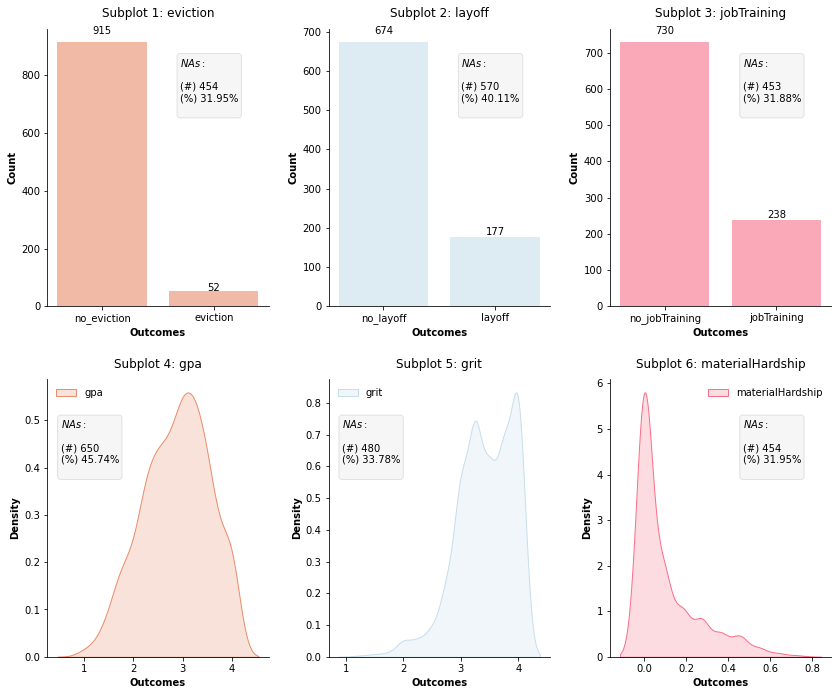

In [458]:
## capture missing values (absolute & percentages in response var)
missing_y_dict_perc = dict(round(y_train.isna().sum()/len(y_train)*100,2))
missing_y_dict_abs = dict(y_train.isna().sum())

# Initialize figure
fig, axes = plt.subplots(2, 3, figsize=(12,10))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
axes = axes.ravel()

#define meta params 
text_props = dict(boxstyle='round',alpha=0.2,facecolor = "lightgrey",edgecolor="grey")
visibility = [False,False,True,True]
spines = ['top','right','left','bottom']
fontweight= "bold"
locs= [2,2,1]
fontsize=10
pad=1.02
class_colors = ['#e98d6b','#c7dfeb','#f77189']

########## CATEGORICAL RESPONSE VARIABLES ########## 

for i,var in enumerate(['eviction', 'layoff', 'jobTraining']):
    
    #condition data for plotting 
    s = y_train.loc[:,var].dropna()
    df= pd.DataFrame(s.value_counts()).reset_index()
    df.rename(columns={"index":"label"},inplace=True)
    df["label"] = df["label"].map({0:f"no_{var}",1: f"{var}"})
    
    #generate plot 
    axes[i].bar(df.label,df[var],color = class_colors[i],alpha=0.6)
    
    #add NA summary stats 
    textstr = '\n'.join((r'$NAs:$',"",f"(#) {missing_y_dict_abs[var]}",f"(%) {missing_y_dict_perc[var]}%\n"))
    axes[i].text(0.6, 0.9, textstr,
                 transform=axes[i].transAxes,
                 fontsize=fontsize,verticalalignment='top', bbox=text_props)
    
    #format plot 
    axes[i].set_title(f"Subplot {i+1}: {var}",fontsize=fontsize*1.2,fontweight="normal",y=pad)
    axes[i].set_xlabel('Outcomes',fontweight=fontweight,fontsize=fontsize)
    axes[i].set_ylabel('Count',fontweight=fontweight,fontsize=fontsize)
    
    for p in axes[i].patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        axes[i].annotate(f'{round(height,2)}', (x + width/2, y + height*1.03), ha='center')
    
    frame_zip = zip(spines,visibility)
    for z in frame_zip:
        axes[i].spines[z[0]].set_visible(z[1])      
        
########## CONTINUOUS RESPONSE VARIABLES ##########   

for i,var in enumerate(y_reg):
    
    #get series 
    s = y_train.loc[:,var].dropna()
    
    #generate plot 
    axes[i+3] = sns.kdeplot(data=s, x=s.values, ax=axes[i+3], color=class_colors[i], cumulative=False,shade=True,bw_adjust=1,label=var)

    #add NA summary stats
    textstr = '\n'.join((r'$NAs:$',"",f"(#) {missing_y_dict_abs[var]}",f"(%) {missing_y_dict_perc[var]}%\n"))
    
    if i != 2:
        
        axes[i+3].text(0.06, 0.86, textstr,
                 transform=axes[i+3].transAxes,
                 fontsize=fontsize,verticalalignment='top', bbox=text_props)
    else:   
        axes[i+3].text(0.6, 0.86, textstr,
             transform=axes[i+3].transAxes,
             fontsize=fontsize,verticalalignment='top', bbox=text_props)
    
    
    #format plot
    axes[i+3].set_title(f"Subplot {i+4}: {var}",fontsize=fontsize*1.2,fontweight="normal",y=pad)
    axes[i+3].set_ylabel('Density',fontweight=fontweight,fontsize=fontsize)
    axes[i+3].set_xlabel('Outcomes',fontweight=fontweight,fontsize=fontsize)
    axes[i+3].legend(frameon=False, loc=locs[i])
    
    frame_zip = zip(spines,visibility)
    for z in frame_zip:
        axes[i+3].spines[z[0]].set_visible(z[1])  
        
fig.tight_layout(pad=2.0)
#plt.savefig("Vis/Fig_6.png")
plt.show()

### APPENDIX - Alternative Response Variable Transforms in comparison 

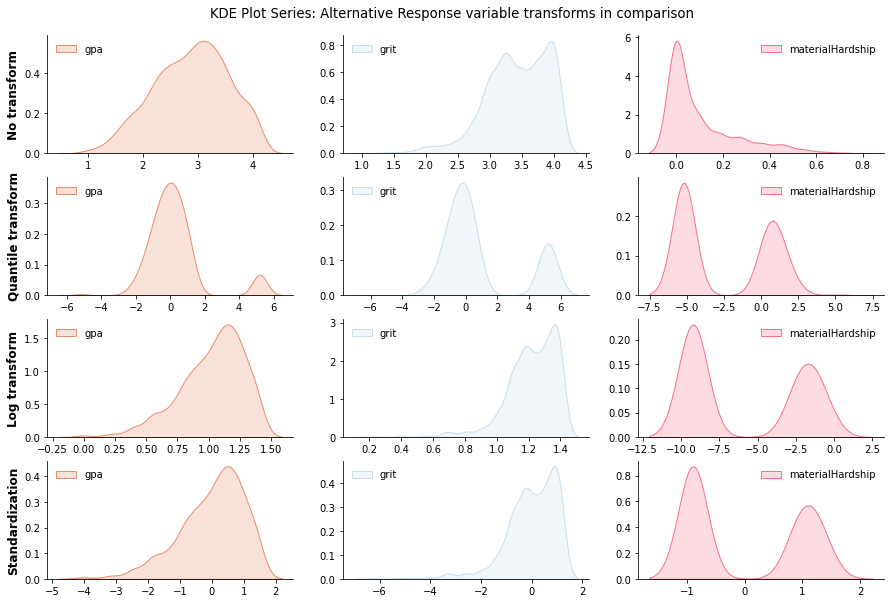

In [61]:
## capture missing values (absolute & percentages in response var)
missing_y_dict_perc = dict(round(y_train.isna().sum()/len(train)*100,2))
missing_y_dict_abs = dict(y_train.isna().sum())

#KDE: smmothing out, continuous version of hist; estimate prob densitfy function from finate dataset, non-parametric way (no dist assumed); depending on kernel (gaussian kernel) (pdf)

# Initialize figure
fig, axes = plt.subplots(4, 3, figsize=(15,10))
axes = axes.ravel()

#specify meta params
locs= [2,2,1]
fontweight="bold"
fontsize=12
class_colors = ['#e98d6b','#c7dfeb','#f77189']
sns.despine()

fig.suptitle('KDE Plot Series: Alternative Response variable transforms in comparison',fontsize=fontsize*1.1,y=0.92)


for i,var in enumerate(y_reg):
    
    s = y_train.loc[:,var].dropna()

    ########## NO TRANSFORM ##########
    
    axes[i] = sns.kdeplot(data=s, x=s.values, ax=axes[i], color=class_colors[i], cumulative=False,shade=True,bw_adjust=1,label=var)
    axes[i].legend(frameon=False, loc=locs[i])
    
    if i == 0:  
        axes[i].set_ylabel("No transform",fontweight=fontweight, fontsize=fontsize)
    else:
        axes[i].set_ylabel("",fontweight=fontweight, fontsize=fontsize)
    
    ########## QUANTILE TRANSFORM ##########
    
    trans = QuantileTransformer(n_quantiles=len(s),output_distribution='normal')
    
    data_trans = pd.DataFrame(trans.fit_transform(s.values.reshape(-1,1)),columns = [var])
    
    axes[i+3] = sns.kdeplot(data=data_trans, x=data_trans[var].values, ax=axes[i+3], color=class_colors[i], cumulative=False,shade=True,bw_adjust=1,label=var)
    axes[i+3].legend(frameon=False, loc=locs[i])
    
    if i == 0:
        axes[i+3].set_ylabel("Quantile transform",fontweight=fontweight, fontsize=fontsize)
    else:
        axes[i+3].set_ylabel("",fontweight=fontweight, fontsize=fontsize)
        
    ########## LOG TRANSFORM ##########
    
    s = np.log(s+0.0001)
    
    axes[i+6] = sns.kdeplot(data=s, x=s.values, ax=axes[i+6], color=class_colors[i], cumulative=False,shade=True,bw_adjust=1,label=var)
    axes[i+6].legend(frameon=False, loc=locs[i])
    
    if i == 0:
        axes[i+6].set_ylabel("Log transform",fontweight=fontweight, fontsize=fontsize)
    else: 
        axes[i+6].set_ylabel("",fontweight=fontweight, fontsize=fontsize)
        

    ########## Standardization ##########
    
    scaler = StandardScaler()
    
    s = scaler.fit_transform(s.values.reshape(-1,1))
    
    axes[i+9] = sns.kdeplot(data=s, x=s.squeeze(), ax=axes[i+9], color=class_colors[i], cumulative=False,shade=True,bw_adjust=1,label=var)
    axes[i+9].legend(frameon=False, loc=locs[i])
    
    if i == 0: 
        axes[i+9].set_ylabel("Standardization",fontweight=fontweight, fontsize=fontsize)
    else:
        axes[i+9].set_ylabel("",fontweight=fontweight, fontsize=fontsize)


#fig.tight_layout()
#plt.savefig("Vis/Fig_7.png")
plt.show()

## Pre-Process Datasets for Modelling

In [ ]:
#################################################################################################################################
## PLEASE NOTE: Output had to be removed since convergence warning for iterative imputer (due to small amount of imputation  ####
## iterations) revealed folder path with candidate name                                                                    ######
#################################################################################################################################

#transform: "True" / "False"
#imputation: "multivar" / "simple"
#ohe: "True"/"False"
#mi_select: "None","0.25","0.5","0.75"

#parent dictionary to store pre-processed datasets across cofigs
output_collector_dict =defaultdict(dict)
#parent dictionary to store pre-processed datasets across cofigs
mi_collector_dict =defaultdict(dict)

#candidate config dicts

# "baseline"
#config_dict_1 = dict(transform="False",imputation="simple", ohe="True", mi_select="None") 

#simple imputation across pruning fractions
config_dict_2 = dict(transform="True",imputation="simple", ohe="True", mi_select="None") 
config_dict_3 = dict(transform="True",imputation="simple", ohe="True", mi_select="0.25") 
config_dict_4 = dict(transform="True",imputation="simple", ohe="True", mi_select="0.5") 
#config_dict_5 = dict(transform="True",imputation="simple", ohe="True", mi_select="0.75")

#multivariate imputation across pruning fractions

config_dict_6 = dict(transform="True",imputation="multivar", ohe="True",mi_select="None") 
config_dict_7 = dict(transform="True",imputation="multivar", ohe="True",mi_select="0.25") 
config_dict_8 = dict(transform="True",imputation="multivar", ohe="True",mi_select="0.5") 
#config_dict_9 = dict(transform="True",imputation="multivar", ohe="True",mi_select="0.75") 


#create config list
candidate_config_list =[config_dict_2,config_dict_3,config_dict_4,config_dict_6,config_dict_7,config_dict_8]

#iterate over all configs per responsevariable: 6*4 > 24 combinations
counter = 0 

#creating datasets for continuous variables 
for variable in y_reg + y_class:
    
    for config in candidate_config_list:
        counter = pp_pipeline(counter,X_train,y_train,X_CV,y_CV,variable,config,output_collector_dict,mi_collector_dict,verbose=True) 

## Train Models across response variables

In [76]:
#instantiate dict to capture outputs
lgbm_output = defaultdict(dict)

#train models on continuous variables
for variable in y_reg:
    model_pipeline(output_collector_dict,lgbm_output,variable,"LightGBM",iterations=15)

Model LightGBM: Trial datasets fro response: gpa
Model on dataset series 1/6 Spec: transform:True-imputation:simple-ohe:True-mi_select:None
Train model in gpa
Finished training in 1.61mins.
Best Params	{'colsample_bytree': 0.7681925250694946, 'learning_rate': 0.02704376076034095, 'max_depth': 4, 'min_child_samples': 200, 'n_estimators': 882, 'num_leaves': 23, 'seed': 42, 'subsample': 0.7831187709902608, 'subsample_freq': 6}
Best Score	0.12694366353161185
Test r2	0.10515355141197591
Model on dataset series 2/6 Spec: transform:True-imputation:simple-ohe:True-mi_select:0.25
Train model in gpa
Finished training in 1.26mins.
Best Params	{'colsample_bytree': 0.43810094919554987, 'learning_rate': 0.027993308650245595, 'max_depth': 5, 'min_child_samples': 181, 'n_estimators': 260, 'num_leaves': 24, 'seed': 42, 'subsample': 0.7386877284035367, 'subsample_freq': 6}
Best Score	0.1462192793633373
Test r2	0.14251363487585222
Model on dataset series 3/6 Spec: transform:True-imputation:simple-ohe:Tru

In [87]:
#train models on discrete variables
for variable in y_class:
    model_pipeline(output_collector_dict,lgbm_output,variable,"LightGBM",iterations=10)

Model LightGBM: Trial datasets fro response: eviction
Model on dataset series 1/6 Spec: transform:True-imputation:simple-ohe:True-mi_select:None
Train model in eviction
Finished training in 4.96mins.
Best Params	{'colsample_bytree': 0.6620031851551176, 'learning_rate': 0.07674745684960561, 'max_depth': 2, 'min_child_samples': 215, 'n_estimators': 904, 'num_leaves': 20, 'seed': 42, 'subsample': 0.5135751349736513, 'subsample_freq': 4}
Best Score	0.9967808052348728
Test Metrics	AUC: 0.7024070021881837, Accuracy: 0.9227642276422764, F1: 0.049999999999999996,Brier Loss: 0.06850331430777398
Model on dataset series 2/6 Spec: transform:True-imputation:simple-ohe:True-mi_select:0.25
Train model in eviction
Finished training in 2.98mins.
Best Params	{'colsample_bytree': 0.689736968807857, 'learning_rate': 0.05320531641145306, 'max_depth': 3, 'min_child_samples': 159, 'n_estimators': 523, 'num_leaves': 27, 'seed': 42, 'subsample': 0.6558393790668828, 'subsample_freq': 7}
Best Score	0.99890927193

## Visualize Results 

### FIGURE - CV and Test Scores per variable

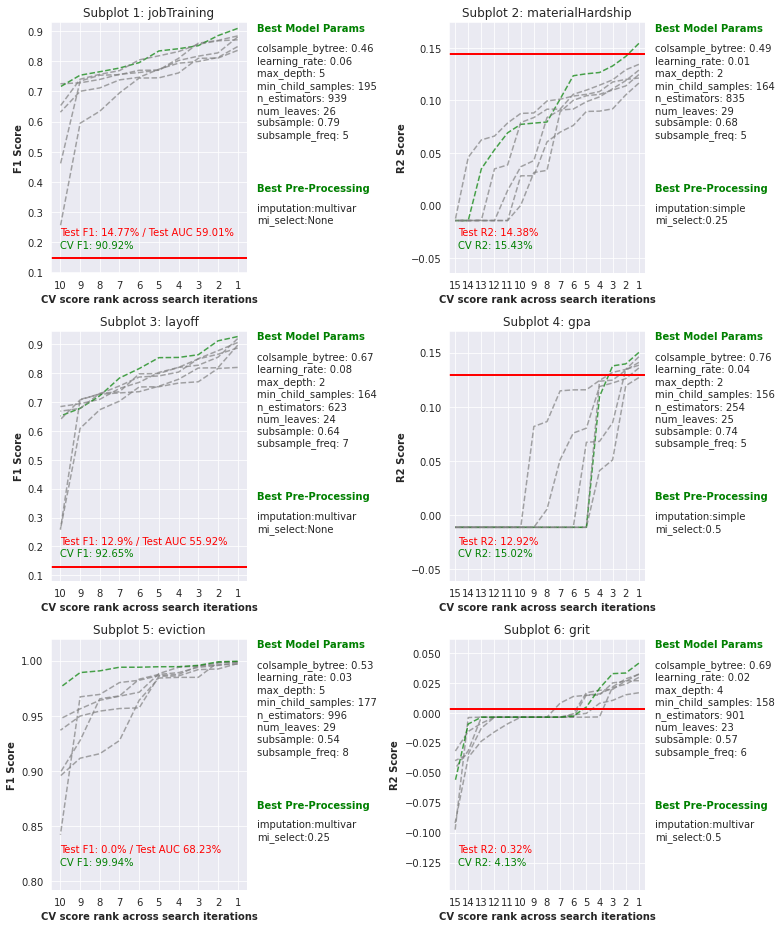

In [383]:
with sns.axes_style("darkgrid"):
    
    #instantiate figure 
    fig, axes = plt.subplots(3,2,figsize=(11,13), sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    axes = axes.ravel()
    
    
    #set meta params 
    hor=1.05
    score_hor = 0.15
    ver = 0.28
    annot_size=10
    
    text_props = dict(boxstyle='round',facecolor = "white",alpha=0)
    fontsize=10
    fontweight="bold"
    
    #interate over response 
    for idx,var in enumerate(['jobTraining','materialHardship',"layoff","gpa","eviction","grit"]):
       
        #res_list = list()
        color_dict = dict()
        
        ##concatenate config results & retrieve best model results for response in question
        df,best_ds = gather_results(lgbm_output,var)

        if var in y_reg:
            iterations=15
            test_score = lgbm_output[var][best_ds][1][0]
        elif var in y_class: 
            iterations=10
            test_score = lgbm_output[var][best_ds][1]
            
        #get params of model yielding highest cv score 
        best_params = [f"{k}: {round(v,2)}" for k,v in df.loc[df["mean_test_score"].idxmax(),"params"].items()if k !="seed"]
        
        #create conditional color dict 
        for c,i in df.groupby("config")["mean_test_score"].max().items():
            
            #highlight dataset yieling best cv score in "green"
            if i == max(df.groupby("config")["mean_test_score"].max()):
                color_dict[c] = "g"
            else: 
                color_dict[c] = "grey"
                    
        # allocating decreasing ranks for enable plotting of equivalently ranked outcomes (sklearn repeats rank score out of the box)
        df_list = list()

        for col in df["config"].unique():

            temp_df = df.loc[df.config==col].sort_values("rank_test_score",ascending=True) 
            temp_df.loc[:,"rank_test_score"] = np.arange(1,iterations+1,1)
            df_list.append(temp_df)
    
        df = pd.concat(df_list)
        
        #generate plots - mean cross val scores across datasets

        axes[idx] = sns.lineplot(data=df, x="rank_test_score", y="mean_test_score", hue="config",ax=axes[idx],alpha=0.7, palette=color_dict,linestyle="--")
        
        #generate plots - horizontal line for test score 
        if var in y_reg: 
            axes[idx].axhline(y=test_score , color='r', linestyle='-',linewidth="2")
        if var in y_class:
            axes[idx].axhline(y=test_score[2] , color='r', linestyle='-',linewidth="2")
        
        #format plot 
        axes[idx].set_xticks(sorted(np.arange(1,iterations+1),reverse=True))
        
        
        if var in y_reg:
        
            axes[idx].set_ylim(df["mean_test_score"].min()-0.05,df["mean_test_score"].max()+0.02)
            axes[idx].set_xlim(0.5,iterations+0.5)
            
        elif var in y_class:
      
            if var != "eviction":
                axes[idx].set_ylim(test_score[2]-0.05,df["mean_test_score"].max()+0.02)
            else:
                axes[idx].set_ylim(df["mean_test_score"].min()-0.05,df["mean_test_score"].max()+0.02)
                
            axes[idx].set_xlim(0.5,iterations+0.5)
        
        axes[idx].invert_xaxis()
        
        if var in y_reg:
            axes[idx].set_ylabel("R2 Score",fontweight="bold",fontsize=fontsize)
        if var in y_class:
            axes[idx].set_ylabel("F1 Score",fontweight="bold",fontsize=fontsize)
        
        axes[idx].set_xlabel("CV score rank across search iterations",fontweight="bold",fontsize=fontsize)
        axes[idx].set_title(f"Subplot {idx+1}: {var}",fontweight="normal",fontsize=fontsize*1.2)
    
        #annotate plot 
        axes[idx].text(hor,ver,'Best Pre-Processing\n',transform=axes[idx].transAxes,fontsize=annot_size,color="g",fontweight="bold")
        
        axes[idx].text(hor,ver,"\n".join(pd.Series(best_ds.split("-")).iloc[[1,3]].values.tolist()),
                  transform=axes[idx].transAxes,
                  fontsize=annot_size,verticalalignment='top', bbox=text_props)
        
        axes[idx].text(hor,ver+0.64,'Best Model Params\n',transform=axes[idx].transAxes,fontsize=annot_size,color="g",fontweight="bold")
        
        axes[idx].text(hor,ver+0.64,"\n".join(best_params),
                  transform=axes[idx].transAxes,
                  fontsize=annot_size,verticalalignment='top', bbox=text_props)
        
        if var in y_reg:
            axes[idx].text(0.05,score_hor,f"Test R2: {round(test_score*100,2)}%",
                           transform=axes[idx].transAxes,fontsize=annot_size,color="r")
            axes[idx].text(0.05,score_hor-0.05,f"CV R2: {round(df['mean_test_score'].max()*100,2)}%",
                           transform=axes[idx].transAxes,fontsize=annot_size,color="g")
        if var in y_class:
            axes[idx].text(0.05,score_hor,f"Test F1: {round(test_score[2]*100,2)}% / Test AUC {round(test_score[0]*100,2)}% ",
                           transform=axes[idx].transAxes,fontsize=annot_size,color="r")
            axes[idx].text(0.05,score_hor-0.05,
                           f"CV F1: {round(df['mean_test_score'].max()*100,2)}%",
                           transform=axes[idx].transAxes,fontsize=annot_size,color="g")
        
        axes[idx].legend().remove()

plt.tight_layout()   
#plt.savefig("Vis/Fig_8.png")
plt.show()

### APPENDIX - Confusion Matrix Results for outcome "eviction"

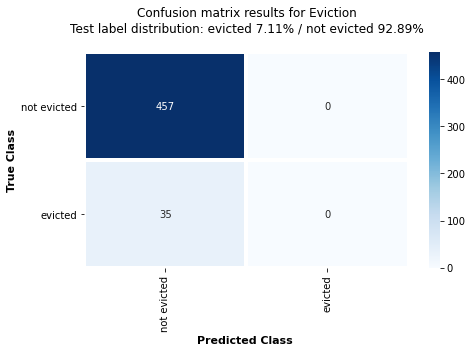

In [420]:
fig, ax = plt.subplots(figsize=(7, 5))

#set meta params 
fontweight="bold"
fontsize=11
evict_dict = {1:"evicted",0:"not evicted"}

#get share of positive and negative outcomes in test set
true_neg = output_collector_dict["eviction"]["transform:True-imputation:multivar-ohe:True-mi_select:0.25"][3].value_counts(normalize=True).loc[0]
true_pos = output_collector_dict["eviction"]["transform:True-imputation:multivar-ohe:True-mi_select:0.25"][3].value_counts(normalize=True).loc[1]

#generate plot
ax = sns.heatmap(lgbm_output["eviction"]["transform:True-imputation:multivar-ohe:True-mi_select:0.25"][1][3],
            annot = True, fmt = 'g',linewidth=3,cmap="Blues",ax=ax)

#format plot 
xlabels = [idx for idx,_ in enumerate(ax.get_xticks())]
ax.set_xticklabels([evict_dict[i]for i in xlabels])
ylabels = [idx for idx,_ in enumerate(ax.get_xticks())]
ax.set_yticklabels([evict_dict[i]for i in xlabels])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    
ax.set_xlabel("Predicted Class ",fontsize=fontsize,fontweight=fontweight)
ax.set_ylabel("True Class",fontsize=fontsize,fontweight=fontweight)
ax.set_title(f"Confusion matrix results for Eviction\nTest label distribution: evicted {round(true_pos*100,2)}% / not evicted {round(true_neg*100,2)}%\n",
             fontsize=fontsize*1.1,fontweight="normal")

plt.tight_layout()   
#plt.savefig("Vis/Fig_14.png")
plt.show()

### FIGURE - Feature importances across best models

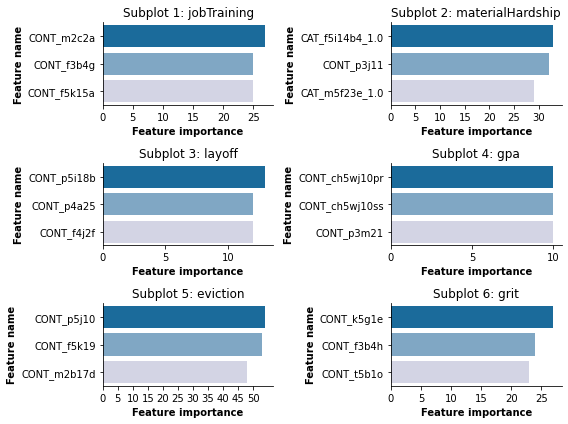

In [456]:
fig, axes = plt.subplots(3,2,figsize=(8,6), sharey=False)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

axes = axes.ravel()

fontweight = "bold"
fontsize = 10
top_k  = 3

top_k_dict = dict()

for idx,var in enumerate(['jobTraining','materialHardship',"layoff","gpa","eviction","grit"]):

    ##concatenate config results & retrieve best model results for response in question
    df,best_ds = gather_results(lgbm_output,var)
    
    #retrive feature importances 
    var_columns = output_collector_dict[var][best_ds][0].columns.tolist()
    feature_imp_score = lgbm_output[var][best_ds][2].best_estimator_.feature_importances_
    df = pd.DataFrame(zip(var_columns,feature_imp_score),columns=["feature","importance_score"]).sort_values("importance_score",ascending=False).head(top_k)
    
    top_k_dict[var] = df.iloc[:top_k,0].values
    
    axes[idx] = sns.barplot(data=df, y='feature', x='importance_score',ax=axes[idx],dodge=False, palette='PuBu_r')
    
    axes[idx].set_xticks(np.arange(0,df.importance_score.max()+1,5))
    axes[idx].set_ylabel("Feature name",fontweight=fontweight,fontsize=fontsize)
    axes[idx].set_xlabel("Feature importance",fontweight="bold",fontsize=fontsize)
    axes[idx].set_title(f"Subplot {idx+1}: {var}",fontweight="normal",fontsize=fontsize*1.2)
    
    sns.despine()
    
plt.tight_layout()   
#plt.savefig("Vis/Fig_10.png")
plt.show()

### APPENDIX- Most Mutually informative features of best models relying on MI-based feature pruning 

In [452]:
#display most important features in df 
importance_df = pd.DataFrame.from_dict(top_k_dict).T.rename(columns={k:k+1 for k in range(0,top_k)})
#display(importance_df.T)

#retrive question text from metadata dict 
question_df= pd.DataFrame(columns = ["response_var","feature","feature_text"])

counter = 0
for col in importance_df.T.columns:
    
    temp_df = importance_df.T.loc[:,col]
    
    for f in temp_df:
        
        question_df.loc[counter,:] = [col,f,metadata_df.loc[metadata_df.new_name == f.split("_")[1],"varlab"].values[0]]
        counter +=1
        
display(question_df.style.set_properties(subset=['feature_text'], **{'width': '600px'}))

### For LATEX ###
#with pd.option_context("max_colwidth", 1000):
#    print(question_df.to_latex(index=False))

### APPENDIX- Most Mutually informative features of best models relying on MI-based feature pruning 

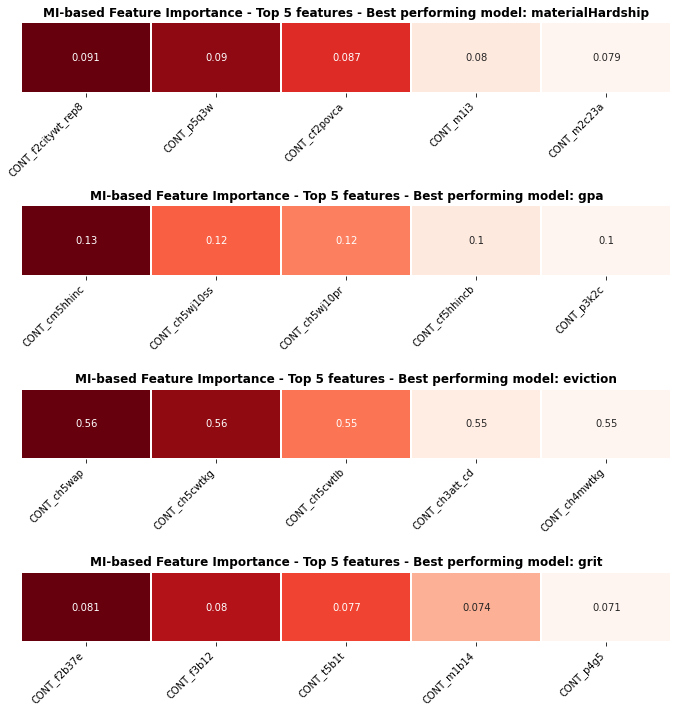

In [441]:
#create empty objects to collect reponse variable and associated best performing dataset names 
var_list = list()
best_ds_list = list()

#instantiate counter to spec plot series length 
counter = 0

#iterate over all possible response variables 
for idx,var in enumerate(['jobTraining','materialHardship',"layoff","gpa","eviction","grit"]):

    df,best_ds = gather_results(lgbm_output,var)
    
    #add best best performing dataset to list if mi-pruning was part of it 
    if "mi_select:None" not in best_ds:
        
        var_list.append(var)
        best_ds_list.append(best_ds)
        
        counter +=  1

#zip resulting response varaible - dataset pairs 
output_zip = zip(var_list,best_ds_list)

#plot results 
plot_mi (output_zip,counter,mi_collector_dict,5,"Vis/Fig_11.png",savefig=False)


### FIGURE - Plot search space of grid search for 2 params of choice 

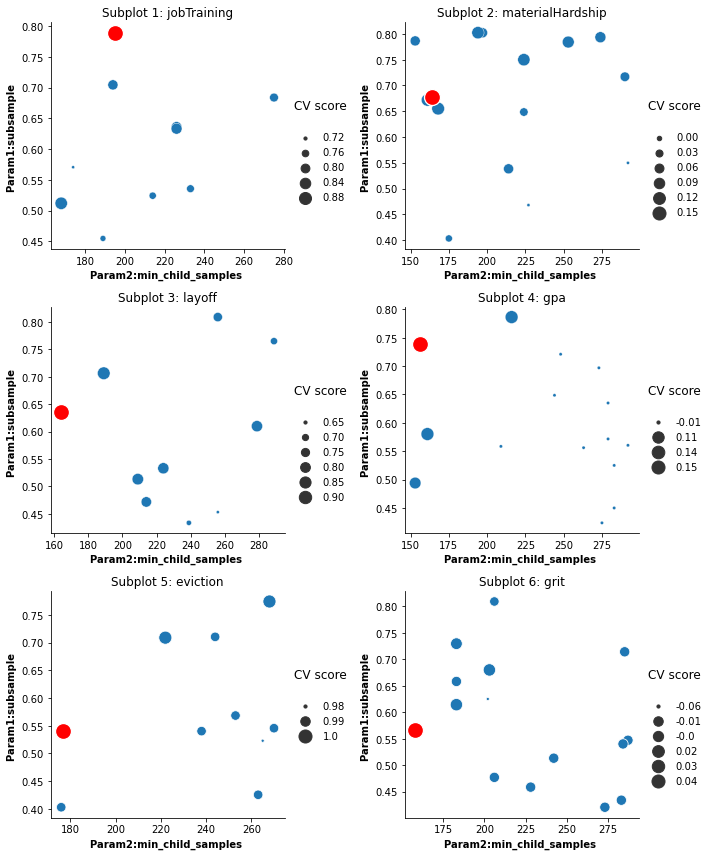

In [446]:
plot_params(['jobTraining','materialHardship',"layoff","gpa","eviction","grit"],lgbm_output,'min_child_samples',"subsample",(10,12),(10,170),"Vis/Fig_9.png",best_pp=True,
            savefig=False)

### APPENDIX - Overview  of  modelling  baselines  resulting  from  different  pre-processing choices

In [449]:
config_list_df = pd.DataFrame(candidate_config_list)
config_list_df.index = range(1,7)
config_list_df.index.name = "Config"

config_list_df
#print(config_list_df.to_latex(index=True))

transform imputation   ohe mi_select
Config                                     
1           True     simple  True      None
2           True     simple  True      0.25
3           True     simple  True       0.5
4           True   multivar  True      None
5           True   multivar  True      0.25
6           True   multivar  True       0.5